In [25]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

## Загрузка данных

In [26]:
df = pd.read_csv('simpsons_script_lines.csv', sep=',', on_bad_lines='skip')

/var/folders/dx/jw53r48d1tx21ndwg6f4_0jc0000gn/T/ipykernel_30552/3744688842.py:1: DtypeWarning: Columns (4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('simpsons_script_lines.csv', sep=',', on_bad_lines='skip')


In [27]:
df.head()

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
0,9549,32,209,"Miss Hoover: No, actually, it was a little of ...",848000,True,464.0,3.0,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometim...",no actually it was a little of both sometimes ...,31.0
1,9550,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,True,9.0,3.0,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,wheres mr bergstrom,3.0
2,9551,32,211,Miss Hoover: I don't know. Although I'd sure l...,856000,True,464.0,3.0,Miss Hoover,Springfield Elementary School,I don't know. Although I'd sure like to talk t...,i dont know although id sure like to talk to h...,22.0
3,9552,32,212,Lisa Simpson: That life is worth living.,864000,True,9.0,3.0,Lisa Simpson,Springfield Elementary School,That life is worth living.,that life is worth living,5.0
4,9553,32,213,Edna Krabappel-Flanders: The polls will be ope...,864000,True,40.0,3.0,Edna Krabappel-Flanders,Springfield Elementary School,The polls will be open from now until the end ...,the polls will be open from now until the end ...,33.0


In [28]:
df = df[['raw_character_text', 'normalized_text']]

In [29]:
df = df.dropna()

## word2vec

In [30]:
def tokenize(text):
    return text.split()

In [31]:
df['tokens'] = df['normalized_text'].apply(tokenize)

In [32]:
sentences = df['tokens'].tolist()

model = Word2Vec(
    sentences,
    vector_size=100, 
    window=5,         
    min_count=2,      
    workers=4,        
    sg=1              
)

## embeddings по самым частотным словам (top 1000)

In [33]:
vocab_words = model.wv.index_to_key  
top_1000_words = vocab_words[:1000]

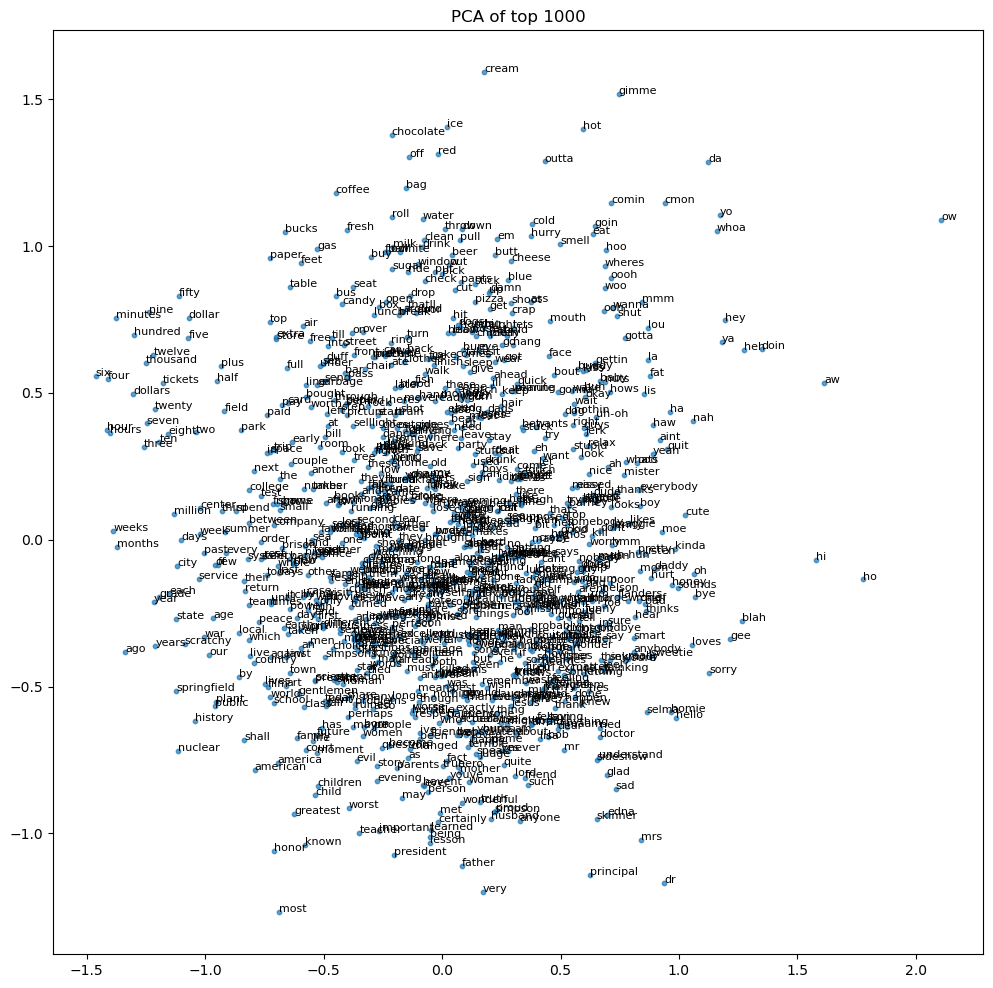

In [34]:
X = np.array([model.wv[word] for word in top_1000_words])

pca = PCA(n_components=2)
coords = pca.fit_transform(X)

plt.figure(figsize=(12, 12))
plt.scatter(coords[:, 0], coords[:, 1], s=10, alpha=0.7)

for i, word in enumerate(top_1000_words):
    x, y = coords[i, 0], coords[i, 1]
    plt.text(x, y, word, fontsize=8)
    
plt.title('PCA of top 1000')
plt.show()

## самые близкие слова для: homer - marge + bart bart - lisa + school marge - homer + home

In [35]:
operations = {
    "homer - marge + bart": ("homer", "marge", "bart"),
    "bart - lisa + school": ("bart", "lisa", "school"),
    "marge - homer + home": ("marge", "homer", "home")
}

results = {}
for op, (w1, w2, w3) in operations.items():
    res_vector = model.wv[w1] - model.wv[w2] + model.wv[w3]
    similar_words = model.wv.most_similar([res_vector], topn=5)
    results[op] = similar_words

for op, similar in results.items():
    print(f"Операция: {op}")
    for word, similarity in similar:
        print(f"  {word}: {similarity:.3f}")
    print("-" * 40)

Операция: homer - marge + bart
  bart: 0.860
  homer: 0.785
  grampa: 0.718
  nelson: 0.673
  bartholomew: 0.662
----------------------------------------
Операция: bart - lisa + school
  school: 0.867
  library: 0.648
  church: 0.642
  zoo: 0.640
  hospital: 0.634
----------------------------------------
Операция: marge - homer + home
  home: 0.864
  sleep: 0.669
  shopping: 0.666
  prom: 0.653
  bed: 0.652
----------------------------------------


## классификатор Bart vs. Lisa с использованием эмбеддингов

In [36]:
df_bart_lisa = df[df['raw_character_text'].isin(['Bart Simpson', 'Lisa Simpson'])].copy()

df_bart_lisa['label'] = df_bart_lisa['raw_character_text'].apply(
    lambda x: 1 if x == 'Bart Simpson' else 0
)

In [37]:
def get_embedding(tokens, w2v_model):
    vectors = []
    for t in tokens:
        if t in w2v_model.wv:
            vectors.append(w2v_model.wv[t])
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(w2v_model.vector_size)

df_bart_lisa['embedding'] = df_bart_lisa['tokens'].apply(lambda ts: get_embedding(ts, model))

In [38]:
X = np.stack(df_bart_lisa['embedding'].values)  
y = df_bart_lisa['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Точность: {acc:.4f}")

Точность: 0.6093
